In [1]:
import warnings
warnings.filterwarnings('ignore')
import geopandas as gpd
from geopandas.tools import overlay
import matplotlib.pyplot as plt
import os 
import sys
module_path = os.path.abspath(os.path.join('../../../'))
if module_path not in sys.path:
    sys.path.append(module_path)
    import aup
import pandas as pd
import numpy as np
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, confusion_matrix
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import StandardScaler
from sklearn.naive_bayes import GaussianNB
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import AdaBoostClassifier
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV 
import xgboost as xgb
import random
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import classification_report, mean_squared_error
#import tensorflow as tf
#from keras.models import Sequential
#from keras.layers import Dense
#from tensorflow.keras.utils import to_categorical

## Espacios Públicos Puebla

In [2]:
schema = 'espacios_publicos'
table = 'ep_puebla'
gdf = aup.gdf_from_db(table,schema)
gdf.head()

,NUMERO CONSECUTIVO,NOMBRE,TIPO,UBICACION,COLONIA,SUPERFICIE (EN METROS CUADRADOS),LATITUD,LONGITUD,geometry
0,1,3 DE MAYO,PARQUE,CALLE PRIMERO DE MAYO ENTRE 16 DE SEPTIEMBRE Y...,3 DE MAYO,1.20,19.08563,-98.16091,POINT (-98.16091 19.08563)
1,2,5 DE FEBRERO ORIENTE 1,JARDÍN VECINAL,ENTRE RETORNO A Y RETORNO B,INFONAVIT BOSQUES 5 DE FEBRERO,139.00,19.08349,-98.20219,POINT (-98.20219 19.08349)
2,3,5 DE FEBRERO ORIENTE 2,JARDÍN VECINAL,ENTRE RETORNO B Y REOTORNO C,INFONAVIT BOSQUES 5 DE FEBRERO,157.00,19.08336,-98.20180,POINT (-98.20180 19.08336)
3,4,5 DE FEBRERO ORIENTE 3,JARDÍN VECINAL,ENTRE RETORNO C Y CALLE 27 NORTE,INFONAVIT BOSQUES 5 DE FEBRERO,76.20,19.08323,-98.20134,POINT (-98.20134 19.08323)
4,5,5 DE FEBRERO ORIENTE 4,JARDÍN VECINAL,5 DE FEBRERO ORIENTE Y RETORNO A,INFONAVIT BOSQUES 5 DE FEBRERO,103.00,19.08364,-98.20259,POINT (-98.20259 19.08364)


In [11]:
gdf.shape

(509, 9)

## Hexágonos Puebla

In [3]:
hex_schema = "raster_analysis"
hex_table = "ndmi_analysis_hex"
c = 'Puebla'
n = '11'
query = f'SELECT hex_id, geometry, city FROM {hex_schema}.{hex_table} WHERE \"city\" LIKE \'{c}\' AND \"res\" = {n}'
hex_gdl = aup.gdf_from_query(query, geometry_col='geometry')
#query = 'fSelect geometry, hex_id, city from raster_analysis.ndvi_analysis where city = guadalajara and res = 11'
hex_gdl.head(5)

,hex_id,geometry,city
0,8b4995c164adfff,"POLYGON ((-98.46955 19.22028, -98.46938 19.220...",Puebla
1,8b4995c16414fff,"POLYGON ((-98.46975 19.21884, -98.46957 19.219...",Puebla
2,8b4995c16528fff,"POLYGON ((-98.47282 19.21578, -98.47264 19.216...",Puebla
3,8b4995c1649bfff,"POLYGON ((-98.46709 19.22219, -98.46691 19.222...",Puebla
4,8b4995c16581fff,"POLYGON ((-98.46861 19.21750, -98.46843 19.217...",Puebla


In [4]:
hex_gdl.shape

(400000, 3)

In [6]:
gdf = gdf.set_crs("EPSG:4326")
hex_gdl = hex_gdl.set_crs("EPSG:4326")
print("CRS of gdf:", gdf.crs)
print("CRS of hex_gdl:", hex_gdl.crs)

CRS of gdf: EPSG:4326
CRS of hex_gdl: EPSG:4326


## Dummy Variables
1 = Hexágonos que cuentan con espacios públicos

0 = Hexágonos que no cuentan con espacios públicos

In [10]:
gdf_sindex = gdf.sindex

# Create a Series of boolean values indicating which hexagons intersect with public spaces
intersects_public_spaces = hex_gdl['geometry'].apply(lambda geom: any(gdf_sindex.query(geom)))

hex_gdl['EspPublico'] = intersects_public_spaces.astype(int)
hex_gdl.head()

,hex_id,geometry,city,EspPublico
0,8b4995c164adfff,"POLYGON ((-98.46955 19.22028, -98.46938 19.220...",Puebla,0
1,8b4995c16414fff,"POLYGON ((-98.46975 19.21884, -98.46957 19.219...",Puebla,0
2,8b4995c16528fff,"POLYGON ((-98.47282 19.21578, -98.47264 19.216...",Puebla,0
3,8b4995c1649bfff,"POLYGON ((-98.46709 19.22219, -98.46691 19.222...",Puebla,0
4,8b4995c16581fff,"POLYGON ((-98.46861 19.21750, -98.46843 19.217...",Puebla,0


In [8]:
contador_ceros = np.sum(hex_gdl['EspPublico'] == 0)
contador_uno = np.sum(hex_gdl['EspPublico'])
print(f'Números de hexagonos sin Espacios Públicos: {contador_ceros} \nNúmero de Hexágonos con Espacios Públicos: {contador_uno}\nNúmero total de Hexágonos: {contador_ceros+contador_uno}')

Números de hexagonos sin Espacios Públicos: 399316 
Número de Hexágonos con Espacios Públicos: 684
Número total de Hexágonos: 400000


Casi el 85% de los hexágonos no cuenta con Espacio Público, los métodos de clasificación van a estar muy sesgados por la discrepancia. Entonces tenemos que hacer que sean 50% ambos pero para esto vamos a hacer un submuestreo random con 50,000 y 50,000 de cada tipo de hexágono pero eso se hará después de juntar todo con el otro GeoDataFrame. Esto es porque nada más tenemos 100,000 hexágonos comparados al de Guadalajara que tenía 400,000.

## Hexágonos con info de humedad, vegetación y temperatura

select {ndmi}.hex_id, {ndmi}.geometry, {ndmi}.city, {ndmi}.res,

ndvi_mean, ndvi_std, ndvi_median, ndvi_max, ndvi_min, ndvi_diff, ndvi_tend,

ndmi_mean, ndmi_median, ndmi_diff

from raster_analysis.ndmi_analysis_hex ndmi

inner join raster_analysis.ndvi_analysis_hex ndvi

on ndmi.hex_id = ndvi.hex_id 

where ndmi.city  = 'Queretaro' and ndmi.res = 11

In [9]:
hex_schema = "raster_analysis"
hex_tablee = "ndvi_analysis_hex"
hex_table = "ndmi_analysis_hex"
ndmi = "ndmi"
ndvi = "ndvi"
hex_id = "hex_id"
c = 'Queretaro'
n = '11'
query = f'SELECT {ndmi}.hex_id, {ndmi}.geometry, {ndmi}.city, {ndmi}.res, ndvi_mean, ndvi_std, ndvi_median, ndvi_max, ndvi_min, ndvi_diff, ndvi_tend,ndmi_mean, ndmi_median, ndmi_diff FROM {hex_schema}.{hex_table} {ndmi} INNER JOIN {hex_schema}.{hex_tablee} {ndvi} ON {ndmi}.{hex_id} = {ndvi}.{hex_id} WHERE {ndmi}.\"city\" = \'{c}\' AND {ndmi}.\"res\" = {n}'
intt_gdl = aup.gdf_from_query(query, geometry_col='geometry')
intt_gdl.head(10)

,hex_id,geometry,city,res,ndvi_mean,ndvi_std,ndvi_median,ndvi_max,ndvi_min,ndvi_diff,ndvi_tend,ndmi_mean,ndmi_median,ndmi_diff
0,8b4983d1ba46fff,"POLYGON ((-100.53017 20.51871, -100.52999 20.5...",Queretaro,11,0.241042,0.122650,0.201550,0.438644,0.145948,0.292696,-0.001347,-0.121908,-0.161379,0.345450
1,8b4983d19099fff,"POLYGON ((-100.53786 20.51092, -100.53768 20.5...",Queretaro,11,0.254851,0.102009,0.232826,0.392993,0.163497,0.229496,-0.001809,-0.040620,-0.070103,0.251981
2,8b4983d2b458fff,"POLYGON ((-100.60660 20.45927, -100.60642 20.4...",Queretaro,11,0.313791,0.150822,0.255961,0.572973,0.167546,0.405426,-0.002164,-0.017576,-0.072553,0.390034
3,8b4983d2b403fff,"POLYGON ((-100.60422 20.45659, -100.60405 20.4...",Queretaro,11,0.281765,0.173203,0.196383,0.609550,0.122954,0.486597,-0.000501,-0.052168,-0.096644,0.430602
4,8b4983d2b599fff,"POLYGON ((-100.60120 20.45556, -100.60102 20.4...",Queretaro,11,0.324605,0.184907,0.250505,0.673712,0.161954,0.511758,-0.001679,-0.054337,-0.104475,0.545667
5,8b4983d2b4a2fff,"POLYGON ((-100.60108 20.45653, -100.60091 20.4...",Queretaro,11,0.360760,0.146593,0.335531,0.605897,0.173569,0.432329,-0.000475,-0.012363,-0.035256,0.411367
6,8b4983d2b45dfff,"POLYGON ((-100.60707 20.45907, -100.60689 20.4...",Queretaro,11,0.311230,0.171977,0.239997,0.609299,0.145596,0.463703,-0.001349,-0.035402,-0.077655,0.391934
7,8b4983d2b59dfff,"POLYGON ((-100.60126 20.45508, -100.60108 20.4...",Queretaro,11,0.310523,0.195602,0.224173,0.669565,0.124714,0.544851,-0.001795,-0.062393,-0.111208,0.552181
8,8b4983d2b440fff,"POLYGON ((-100.60719 20.45811, -100.60701 20.4...",Queretaro,11,0.230548,0.122678,0.189899,0.440805,0.107198,0.333607,-0.000907,-0.034039,-0.077330,0.335211
9,8b4983d2b495fff,"POLYGON ((-100.60008 20.45740, -100.59990 20.4...",Queretaro,11,0.379716,0.183916,0.386669,0.713963,0.162529,0.551434,-0.005563,-0.010611,-0.037118,0.446434


In [12]:
intt_gdl.shape

(99919, 14)

## Intersección

In [11]:
intt_gdl = intt_gdl.set_crs("EPSG:4326")
hex_gdl = hex_gdl.set_crs("EPSG:4326")

In [13]:
inter = gpd.sjoin(hex_gdl, intt_gdl, op='intersects')
inter.drop(columns=['index_right','city_right','res','hex_id_right'], inplace=True)
inter.rename(columns={"hex_id_left": "hex_id","city_left": "city"}, inplace=True)
inter.head()

,hex_id,geometry,city,EspPublico,ndvi_mean,ndvi_std,ndvi_median,ndvi_max,ndvi_min,ndvi_diff,ndvi_tend,ndmi_mean,ndmi_median,ndmi_diff
0,8b4983d2b253fff,"POLYGON ((-100.62070 20.46531, -100.62053 20.4...",Queretaro,0,0.449207,0.110664,0.446942,0.618048,0.321921,0.296127,-0.001214,0.078849,0.043693,0.284751
16,8b4983d2b255fff,"POLYGON ((-100.62123 20.46463, -100.62106 20.4...",Queretaro,0,0.449207,0.110664,0.446942,0.618048,0.321921,0.296127,-0.001214,0.078849,0.043693,0.284751
575,8b4983d2b256fff,"POLYGON ((-100.62035 20.46454, -100.62017 20.4...",Queretaro,0,0.449207,0.110664,0.446942,0.618048,0.321921,0.296127,-0.001214,0.078849,0.043693,0.284751
587,8b4983d2b252fff,"POLYGON ((-100.62029 20.46502, -100.62011 20.4...",Queretaro,0,0.449207,0.110664,0.446942,0.618048,0.321921,0.296127,-0.001214,0.078849,0.043693,0.284751
704,8b4983d2b251fff,"POLYGON ((-100.62118 20.46511, -100.62100 20.4...",Queretaro,0,0.449207,0.110664,0.446942,0.618048,0.321921,0.296127,-0.001214,0.078849,0.043693,0.284751


In [14]:
pd.isna(inter).sum()

hex_id         0
geometry       0
city           0
EspPublico     0
ndvi_mean      0
ndvi_std       0
ndvi_median    0
ndvi_max       0
ndvi_min       0
ndvi_diff      0
ndvi_tend      0
ndmi_mean      0
ndmi_median    0
ndmi_diff      0
dtype: int64

In [15]:
cont_ceros = np.sum(inter['EspPublico'] == 0)
cont_uno = np.sum(inter['EspPublico'])
print(f'Números de hexagonos sin Espacios Públicos: {cont_ceros} \nNúmero de Hexágonos con Espacios Públicos: {cont_uno}\nNúmero total de Hexágonos: {cont_ceros+cont_uno}')

Números de hexagonos sin Espacios Públicos: 576963 
Número de Hexágonos con Espacios Públicos: 100432
Número total de Hexágonos: 677395


In [11]:
inter['EspPublico'].unique()

array([0, 1])

## Submuestreo 50,000 Hexágonos Esp Púb x 50,000 Hexágonos No Esp Púb

In [16]:
num_samples = 50000

# Randomly sample 203,570 hexagons with public spaces
sample_with_public_spaces = inter[inter['EspPublico'] == 1].sample(n=num_samples, random_state=42)

# Randomly sample 203,570 hexagons without public spaces
sample_without_public_spaces = inter[inter['EspPublico'] == 0].sample(n=num_samples, random_state=42)

# Concatenate the two samples to get the final subsample
inter = pd.concat([sample_with_public_spaces, sample_without_public_spaces])
inter.reset_index(drop = True, inplace = True)
inter.head()

,hex_id,geometry,city,EspPublico,ndvi_mean,ndvi_std,ndvi_median,ndvi_max,ndvi_min,ndvi_diff,ndvi_tend,ndmi_mean,ndmi_median,ndmi_diff
0,8b4983cb3ac8fff,"POLYGON ((-100.33654 20.64610, -100.33636 20.6...",Queretaro,1,0.199148,0.107830,0.160131,0.358885,0.106031,0.252853,-0.002560,-0.060502,-0.082133,0.208231
1,8b4983c8598efff,"POLYGON ((-100.39211 20.65144, -100.39193 20.6...",Queretaro,1,0.098431,0.027789,0.102530,0.131297,0.043856,0.087441,-0.000413,-0.050383,-0.055179,0.123648
2,8b4983c13a2afff,"POLYGON ((-100.47062 20.63116, -100.47045 20.6...",Queretaro,1,0.102380,0.021075,0.102720,0.128340,0.076991,0.051349,-0.000695,-0.042088,-0.044818,0.102369
3,8b4983c9b669fff,"POLYGON ((-100.33586 20.76148, -100.33568 20.7...",Queretaro,1,0.178076,0.067961,0.157923,0.287452,0.111996,0.175456,-0.001337,-0.056498,-0.077775,0.179416
4,8b4983d9915cfff,"POLYGON ((-100.38168 20.57507, -100.38150 20.5...",Queretaro,1,0.047897,0.016164,0.052659,0.065911,0.024631,0.041280,-0.000392,-0.082532,-0.087410,0.066060


In [17]:
contador_ceros = np.sum(inter['EspPublico'] == 0)
contador_uno = np.sum(inter['EspPublico'])
print(f'Números de hexagonos sin Espacios Públicos: {contador_ceros} \nNúmero de Hexágonos con Espacios Públicos: {contador_uno}\nNúmero total de Hexágonos: {contador_ceros+contador_uno}')

Números de hexagonos sin Espacios Públicos: 50000 
Número de Hexágonos con Espacios Públicos: 50000
Número total de Hexágonos: 100000


In [18]:
inter.shape

(100000, 14)

Ya está balanceada la base de datos y con un submuestreo random. Entonces ya podemos juntarlo con el otro GeoDataFrame

Verificamos duplicados

## Métodos de Clasificación

In [20]:
x = inter[['ndvi_mean','ndvi_std','ndvi_median','ndvi_max','ndvi_min','ndvi_diff','ndvi_tend','ndmi_mean','ndmi_median','ndmi_diff']]
y = inter['EspPublico']

In [21]:
y.unique()

array([1, 0])

### Regresión Logística

In [22]:
x_train, x_test, y_train, y_test = train_test_split(x,y, test_size = 0.2, random_state = 42)
scaler = StandardScaler()
x_train_scale = scaler.fit_transform(x_train)
x_test_scale = scaler.fit_transform(x_test)

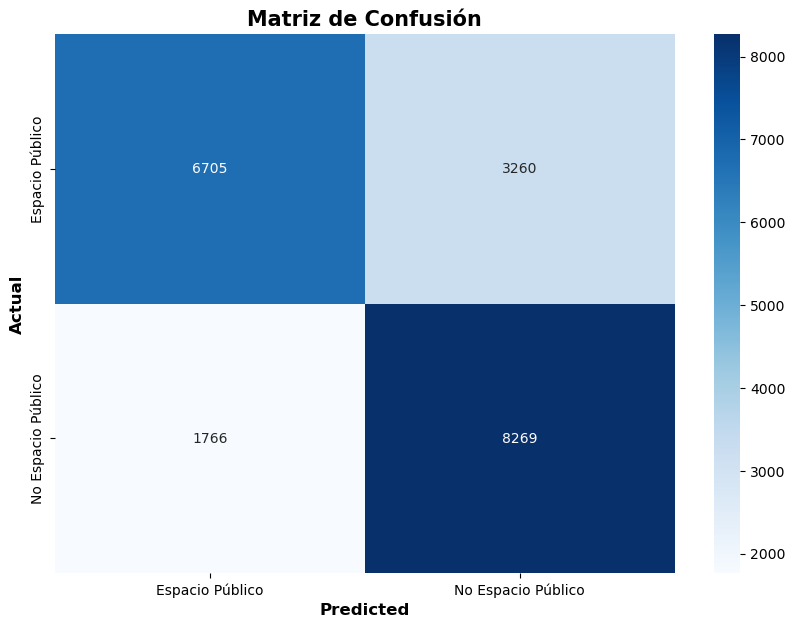

In [23]:
clf = LogisticRegression()
clf.fit(x_train_scale, y_train)
y_pred = clf.predict(x_test_scale)
cm = confusion_matrix(y_test,y_pred)
class_labels = ['Espacio Público', 'No Espacio Público']
plt.figure(figsize = (10,7))
sns.heatmap(cm, annot = True, fmt = "g", cmap="Blues", xticklabels=class_labels, yticklabels=class_labels)
plt.xlabel('Predicted', fontsize = 12, fontweight  = 'bold')
plt.ylabel('Actual', fontsize = 12, fontweight  = 'bold')
plt.title('Matriz de Confusión', fontsize = 15, fontweight = 'bold')
plt.show()

In [24]:
accuracy = accuracy_score(y_test, y_pred)
print(f'Accuracy: {accuracy}')

Accuracy: 0.7487


### Naive Bayes

In [25]:
nb = GaussianNB()
nb.fit(x_train, y_train)

GaussianNB()

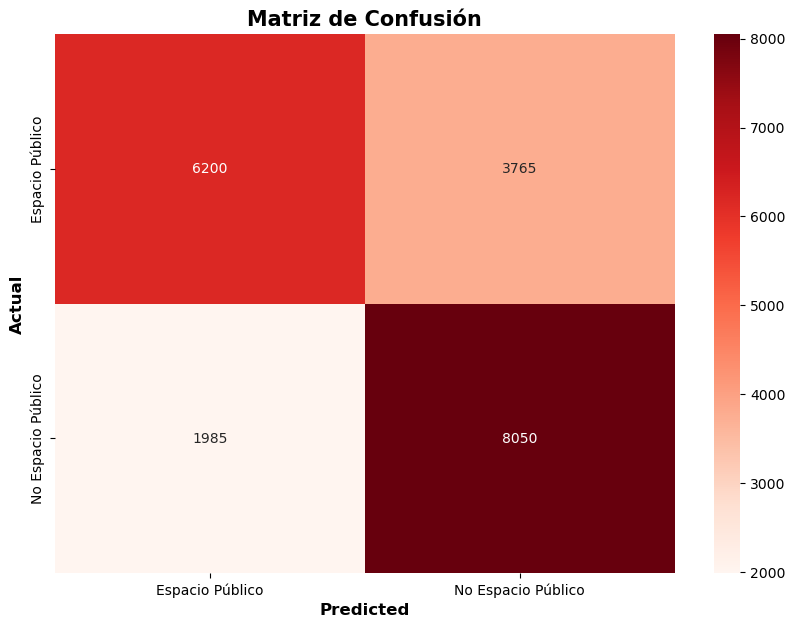

In [26]:
y_prend = nb.predict(x_test)
cm = confusion_matrix(y_test, y_prend)
class_labels = ['Espacio Público', 'No Espacio Público']
plt.figure(figsize = (10,7))
sns.heatmap(cm, annot = True, fmt = "g", cmap="Reds", xticklabels=class_labels, yticklabels=class_labels)
plt.xlabel('Predicted', fontsize = 12, fontweight  = 'bold')
plt.ylabel('Actual', fontsize = 12, fontweight  = 'bold')
plt.title('Matriz de Confusión', fontsize = 15, fontweight = 'bold')
plt.show()

In [27]:
accuracy = accuracy_score(y_test, y_prend)
print(f'Accuracy: {accuracy}')

Accuracy: 0.7125


## Random Forest Classifier (RFC)

In [34]:
rf = RandomForestClassifier(n_estimators=120, random_state=42)  
rf.fit(x_train, y_train)

# Realizar predicciones en el conjunto de prueba
y_predd = rf.predict(x_test)

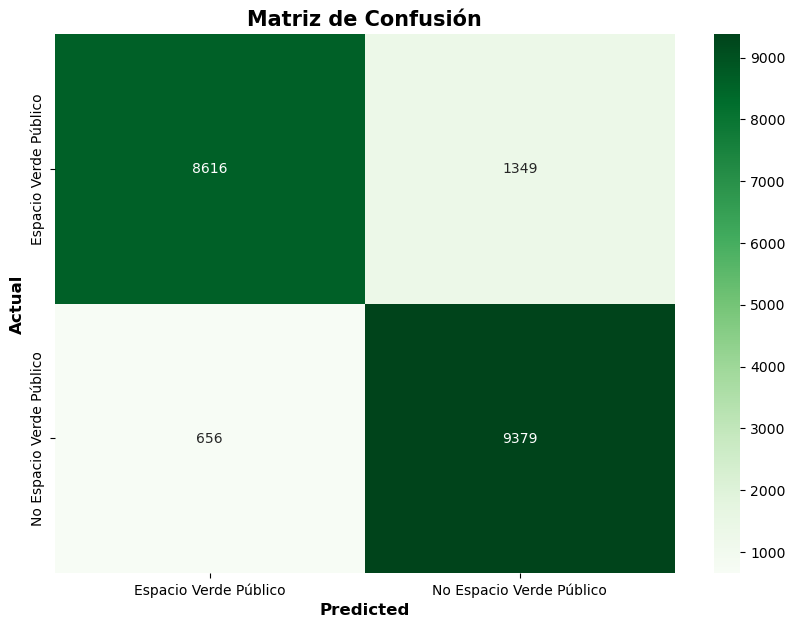

In [35]:
cm = confusion_matrix(y_test, y_predd)
class_labels = ['Espacio Verde Público', 'No Espacio Verde Público']
plt.figure(figsize = (10,7))
sns.heatmap(cm, annot = True, fmt = "g", cmap="Greens", xticklabels=class_labels, yticklabels=class_labels)
plt.xlabel('Predicted', fontsize = 12, fontweight  = 'bold')
plt.ylabel('Actual', fontsize = 12, fontweight  = 'bold')
plt.title('Matriz de Confusión', fontsize = 15, fontweight = 'bold')
plt.show()

In [36]:
accuracy = accuracy_score(y_test, y_predd)
print(f'Accuracy: {accuracy}')

Accuracy: 0.89975


### Optimización Hiperparámetros para obtener la mejor combinación

#### GridSearch

In [18]:
param_grid = { 
    'n_estimators': [25, 50, 100, 125, 150], 
    'max_features': ['sqrt', 'log2', None], 
    'max_depth': [3, 6, 9], 
    'max_leaf_nodes': [3, 6, 9], 
}  

Como tiene mucho costo computacional el hacer una búsqueda exhaustiva y tenemos muchos datos. Voy a hacer un subsample nada más para sacar los mejores híper parámetros y ya después aplicarlos al completo.

In [24]:
sample_size = 10000  
x_train_sample = x_train[:sample_size]
y_train_sample = y_train[:sample_size]
grid_search = GridSearchCV(RandomForestClassifier(), 
                           param_grid=param_grid) 
grid_search.fit(x_train_sample, y_train_sample) 
print(grid_search.best_estimator_) 

RandomForestClassifier(max_depth=6, max_features=None, max_leaf_nodes=9)


In [25]:
rf_grid = RandomForestClassifier(max_depth=6, 
                                    max_features=None, 
                                    max_leaf_nodes=9,
                                    n_estimators=120, 
                                    random_state=42)  
rf_grid.fit(x_train, y_train)

# Realizar predicciones en el conjunto de prueba
y_pred_grid = rf_grid.predict(x_test)

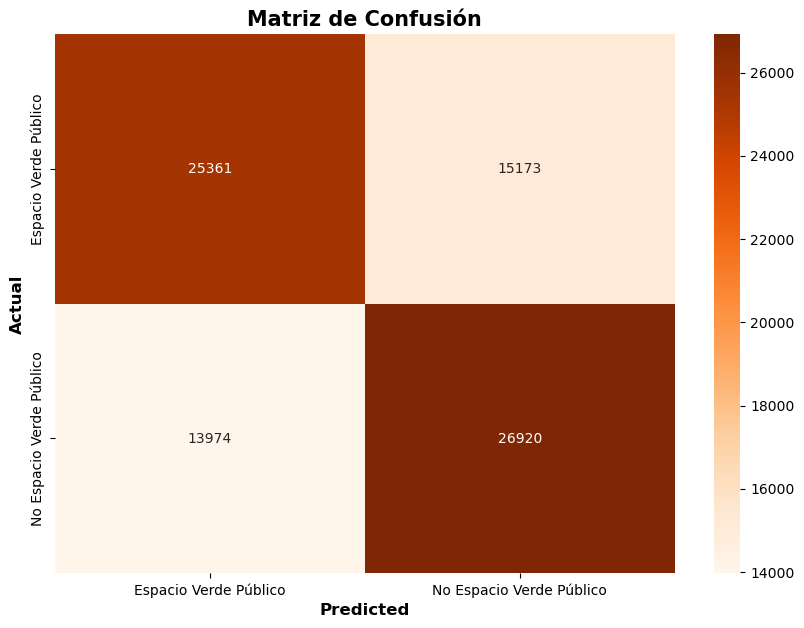

In [26]:
cm = confusion_matrix(y_test, y_pred_grid)
class_labels = ['Espacio Verde Público', 'No Espacio Verde Público']
plt.figure(figsize = (10,7))
sns.heatmap(cm, annot = True, fmt = "g", cmap="Oranges", xticklabels=class_labels, yticklabels=class_labels)
plt.xlabel('Predicted', fontsize = 12, fontweight  = 'bold')
plt.ylabel('Actual', fontsize = 12, fontweight  = 'bold')
plt.title('Matriz de Confusión', fontsize = 15, fontweight = 'bold')
plt.show()

In [27]:
accuracy = accuracy_score(y_test, y_pred_grid)
print(f'Accuracy: {accuracy}')

Accuracy: 0.6420518740482389


Vemos que esos parámetros empeoran terriblemente el accuracy

#### Randomized Search

In [28]:
random_search = RandomizedSearchCV(RandomForestClassifier(), 
                                   param_grid, n_iter=10, n_jobs=-1) 
random_search.fit(x_train, y_train) 
print(random_search.best_estimator_) 

RandomForestClassifier(max_depth=3, max_features=None, max_leaf_nodes=6)


In [29]:
rf_random = RandomForestClassifier(max_depth=3, 
                                    max_features=None, 
                                    max_leaf_nodes=6,
                                    n_estimators=120, 
                                    random_state=42)  
rf_random.fit(x_train, y_train)

# Realizar predicciones en el conjunto de prueba
y_pred_random = rf_random.predict(x_test)

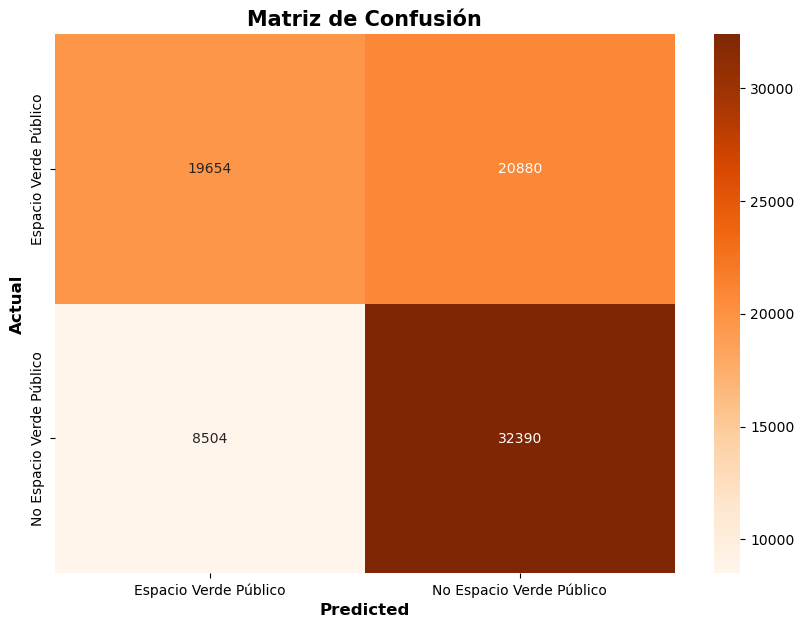

In [30]:
cm = confusion_matrix(y_test, y_pred_random)
class_labels = ['Espacio Verde Público', 'No Espacio Verde Público']
plt.figure(figsize = (10,7))
sns.heatmap(cm, annot = True, fmt = "g", cmap="Oranges", xticklabels=class_labels, yticklabels=class_labels)
plt.xlabel('Predicted', fontsize = 12, fontweight  = 'bold')
plt.ylabel('Actual', fontsize = 12, fontweight  = 'bold')
plt.title('Matriz de Confusión', fontsize = 15, fontweight = 'bold')
plt.show()

In [31]:
accuracy = accuracy_score(y_test, y_pred_random)
print(f'Accuracy: {accuracy}')

Accuracy: 0.63914132730756


#### Ensemble Methods

In [ ]:
from sklearn.ensemble import AdaBoostClassifier

# Example: Using AdaBoost as an ensemble method
ada_boost_model = AdaBoostClassifier(base_estimator=RandomForestClassifier(), n_estimators=50)
ada_boost_model.fit(x_train, y_train)

In [ ]:
y_pred_ada = ada_boost_model.predict(x_test)
cm = confusion_matrix(y_test, y_pred_ada)
class_labels = ['Espacio Verde Público', 'No Espacio Verde Público']
plt.figure(figsize = (10,7))
sns.heatmap(cm, annot = True, fmt = "g", cmap="Oranges", xticklabels=class_labels, yticklabels=class_labels)
plt.xlabel('Predicted', fontsize = 12, fontweight  = 'bold')
plt.ylabel('Actual', fontsize = 12, fontweight  = 'bold')
plt.title('Matriz de Confusión', fontsize = 15, fontweight = 'bold')
plt.show()

In [ ]:
accuracy = accuracy_score(y_test, y_pred_ada)
print(f'Accuracy: {accuracy}')

## XGBoost

In [37]:
xgb_classifier = xgb.XGBClassifier(n_estimators=100, random_state=42)

# Ajustar el modelo a los datos de entrenamiento
xgb_classifier.fit(x_train, y_train)

# Realizar predicciones en el conjunto de prueba
y_predict = xgb_classifier.predict(x_test)

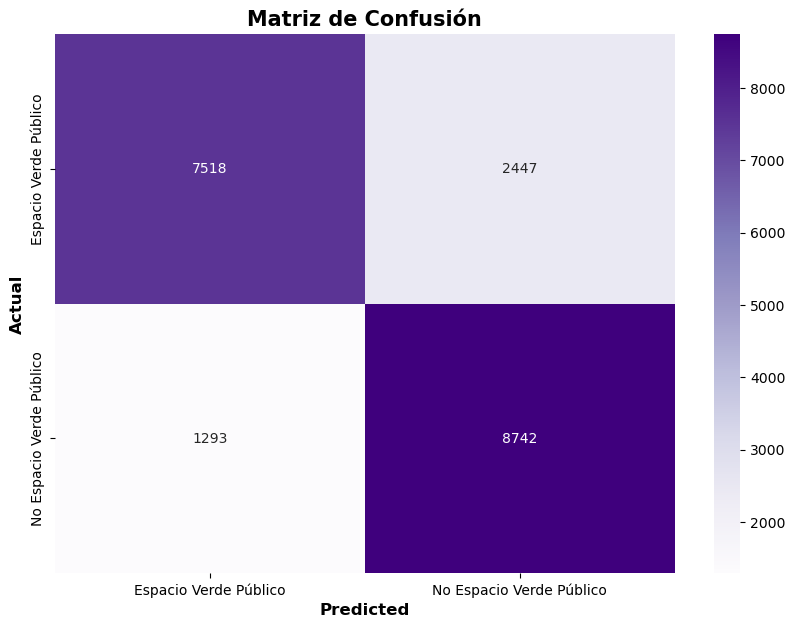

In [38]:
cm = confusion_matrix(y_test, y_predict)
class_labels = ['Espacio Verde Público', 'No Espacio Verde Público']
plt.figure(figsize = (10,7))
sns.heatmap(cm, annot = True, fmt = "g", cmap="Purples", xticklabels=class_labels, yticklabels=class_labels)
plt.xlabel('Predicted', fontsize = 12, fontweight  = 'bold')
plt.ylabel('Actual', fontsize = 12, fontweight  = 'bold')
plt.title('Matriz de Confusión', fontsize = 15, fontweight = 'bold')
plt.show()

In [39]:
accuracy = accuracy_score(y_test, y_predict)
print(f'Accuracy: {accuracy}')

Accuracy: 0.813


Podemos observar que al tener menos datos la clasificación con Naive Bayes, XGBoost y Regresión logística salió peor que con toda la información. Sin embargo, el random forest classifier es el que mejor, ha predecido con un 90% de precisión.

## Clasificación del modelo Perceptrón

In [ ]:
n_clases = len(y.unique())
n_features = len(x.columns)

x = x.values
output_y = y.values

# Define MLP model
clf = Sequential()
clf.add(Dense(180, input_dim=n_features, activation='relu'))
clf.add(Dense(180, activation='relu'))
clf.add(Dense(1, activation='sigmoid')) 

# Compile model
clf.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

# Fit model
clf.fit(x, output_y, epochs=30, batch_size=10)


# Evaluate model with crossvalidation
kf = StratifiedKFold(n_splits=5, shuffle = True)

cv_y_test = []
cv_y_pred = []

for train_index, test_index in kf.split(x, y):

    x_train = x[train_index, :]
    y_train = y[train_index]

    x_test = x[test_index, :]
    y_test = y[test_index]

    # Training phase
    clf_cv = Sequential()
    clf_cv.add(Dense(180, input_dim=n_features, activation='relu'))
    clf_cv.add(Dense(180, activation='relu'))
    clf_cv.add(Dense(1, activation='sigmoid'))
    clf_cv.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
    clf_cv.fit(x_train, y_train, validation_data= (x_test, y_test), epochs=30, batch_size=10)

    # Test phase
    x_test = x[test_index, :]
    y_test = y[test_index]
    y_pred = [0 if valor < 0.5 else 1 for valor in clf_cv.predict(x_test)]
    
    cv_y_test.append(y_test)
    cv_y_pred.append(y_pred)

# Results
print(classification_report(np.concatenate(cv_y_test), np.concatenate(cv_y_pred)))

Epoch 1/30
40000/40000 [==============================] - 309s 8ms/step - loss: 0.6103 - accuracy: 0.6567
Epoch 2/30
40000/40000 [==============================] - 308s 8ms/step - loss: 0.5985 - accuracy: 0.6696
Epoch 3/30
40000/40000 [==============================] - 301s 8ms/step - loss: 0.5944 - accuracy: 0.6736
Epoch 4/30
40000/40000 [==============================] - 320s 8ms/step - loss: 0.5917 - accuracy: 0.6760
Epoch 5/30
40000/40000 [==============================] - 368s 9ms/step - loss: 0.5901 - accuracy: 0.6781
Epoch 6/30
40000/40000 [==============================] - 247s 6ms/step - loss: 0.5884 - accuracy: 0.6794
Epoch 7/30
40000/40000 [==============================] - 294s 7ms/step - loss: 0.5871 - accuracy: 0.6809
Epoch 8/30
40000/40000 [==============================] - 258s 6ms/step - loss: 0.5856 - accuracy: 0.6819
Epoch 9/30
40000/40000 [==============================] - 250s 6ms/step - loss: 0.5849 - accuracy: 0.6826
Epoch 10/30
40000/40000 [=====================